In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler

from text3d2video.camera_trajectories import BarrelRoll, BarrelRollPartial, RotationPartial
from text3d2video.generative_rendering.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)
from text3d2video.rendering import render_depth_map
from text3d2video.video_util import pil_frames_to_clip

torch.set_grad_enabled(False)

model = 'cat'
model = 'mixamo-human'

trajectory = BarrelRollPartial()
trajectory = BarrelRoll()
trajectory = RotationPartial()

anim_artifact = f'{model}_{trajectory.name}:latest'

# read animation
animation = AnimationArtifact.from_wandb_artifact_tag(anim_artifact)
uv_verts, uv_faces = animation.uv_data()

n_frames = 5
frame_indices = animation.frame_indices(n_frames)
cams, mesh_frames = animation.load_frames(frame_indices)

depth_maps = render_depth_map(mesh_frames, cams)
pil_frames_to_clip(depth_maps, duration=1.5).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [4]:
device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from text3d2video.artifacts.gr_data import GrSaveConfig
from text3d2video.generative_rendering.configs import GenerativeRenderingConfig
from text3d2video.noise_initialization import UVNoiseInitializer

module_paths = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=1,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=1.0,
    chunk_size=5,
    num_keyframes=1,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

gr_save_cfg = GrSaveConfig(
    enabled=False,
    n_frames=5,
    n_timesteps=5,
    save_latents=True,
    save_q=False,
    save_k=False,
    save_v=False,
    out_artifact="rumba",
    module_paths=module_paths,
    save_kf_post_attn=False,
    save_aggregated_features=False,
    save_feature_images=False
)

prompt = "Deadpool, simple blank background"

noise_initializer = UVNoiseInitializer()

video_frames = pipe(
    prompt,
    mesh_frames,
    cams,
    uv_verts,
    uv_faces,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    gr_save_config=gr_save_cfg,
)

art = pipe.gr_data_artifact

# display_ims(video_frames)

100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


In [6]:
from text3d2video.video_util import pil_frames_to_clip

pil_frames_to_clip(video_frames, duration=1.5).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [37]:
import os
from text3d2video.sd_feature_extraction import read_layer_paths
print(os.system(f'du -h {art.folder}'))

frame_indices = art.diffusion_data.save_frame_indices
time_steps = art.diffusion_data.save_step_times
modules = art.diffusion_data.save_module_paths

enc_layers, mid_layers, dec_layers = read_layer_paths(modules)

8,0K	/tmp/local_artifacts/gr_data/rumba
0


In [38]:
from einops import rearrange
from PIL import Image

from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.video_util import pil_frames_to_clip

latent_frames = art.latents_writer.read_latents_at_time(time_steps[0])

features = rearrange(latent_frames, "f c h w -> (f h w) c")

pca = RgbPcaUtil.init_from_features(features)

width = 500
latent_frames_rgb = [
    pca.feature_map_to_rgb_pil(frame).resize((width, width), Image.NEAREST)
    for frame in latent_frames
]

pil_frames_to_clip(latent_frames_rgb).ipython_display()

KeyError: 'Unable to synchronously open object (component not found)'

In [17]:
from pathlib import Path

images_path = Path('gr_images')
time = time_steps[2]
layer = dec_layers[-1]
module = layer.module_path()

In [68]:
from einops import rearrange
from torch import Tensor

from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.gr_visualization import render_vert_features

pre_injection_frames = []
rendered_frames = []
post_injection_frames = []
for f in frame_indices:
    pre_injection_frames.append(art.gr_writer.read_post_attn_pre_injection(time, f, module))
    rendered_frames.append(art.gr_writer.read_post_attn_render(time, f, module))
    post_injection_frames.append(art.gr_writer.read_post_attn_post_injection(time, f, module))

keyframe_post_attn = art.gr_writer.read_kf_post_attn(time, module)[0]

vert_features = art.gr_writer.read_vertex_features(time, module)[0]

# fit PCA
features = rearrange(keyframe_post_attn, "b c h w -> (b h w) c")
pca = RgbPcaUtil.init_from_features(features)

rendered_frames_rgb = [pca.feature_map_to_rgb_pil(frame) for frame in rendered_frames]

# PCA to rgb
pre_injection_frames_rgb = [
    pca.feature_map_to_rgb_pil(frame) for frame in pre_injection_frames
]
post_injection_frames_rgb = [
    pca.feature_map_to_rgb_pil(frame) for frame in post_injection_frames
]

keyframe_post_attn_pil = [
    pca.feature_map_to_rgb_pil(fmap) for fmap in keyframe_post_attn
]

vert_features_rgb = Tensor(pca.features_to_rgb(vert_features))

rendered_frames_rgb = render_vert_features(
    mesh_frames[frame_indices], cams[frame_indices], vert_features_rgb, render_res=64
)

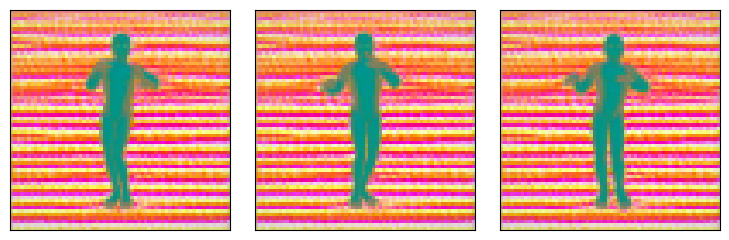

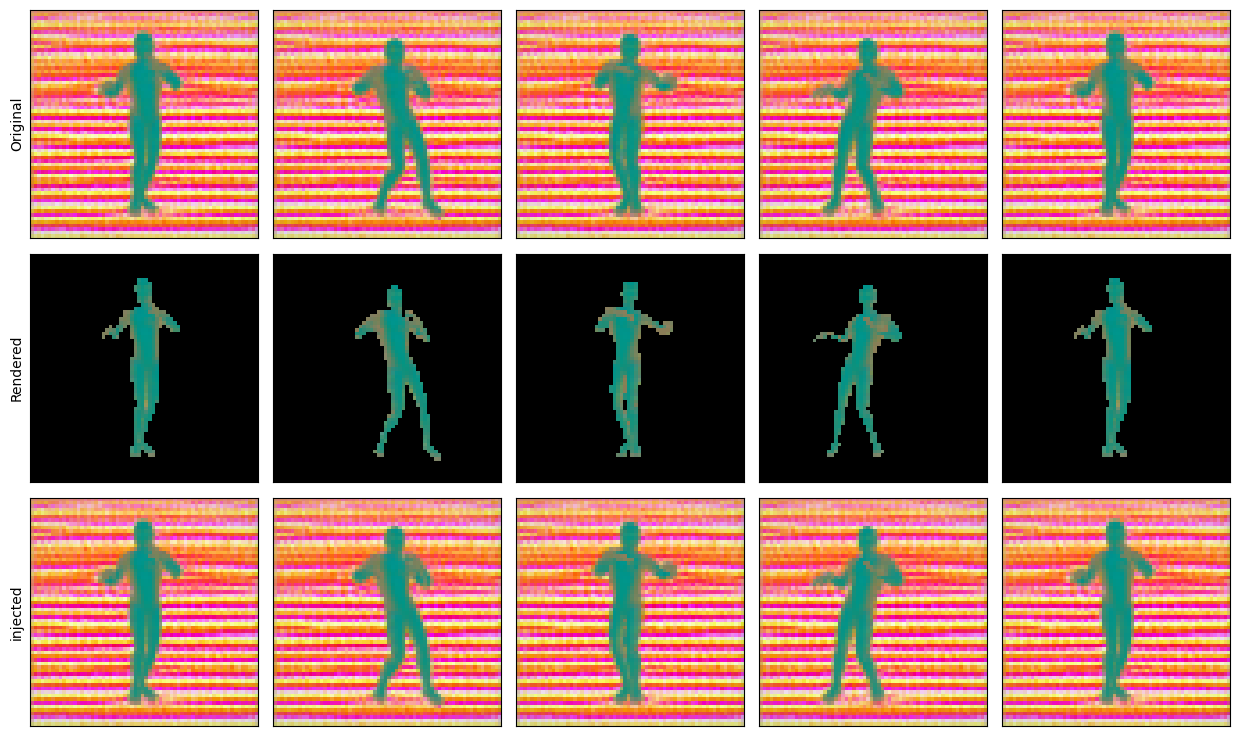

In [69]:
from text3d2video.ipython_utils import display_ims_grid

display_ims_grid([keyframe_post_attn_pil])

display_ims_grid(
    [pre_injection_frames_rgb, rendered_frames_rgb, post_injection_frames_rgb],
    row_titles=["Original", "Rendered", "injected"],
)

In [62]:
frame = frame_indices[0]
time = time_steps[-1]
attn_layer = dec_layers[-1]
module_path = attn_layer.module_path()

# read key/qry/val
qry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)
val = art.attn_writer.read_val(time, frame, module_path)

kf_indices = art.gr_writer.read_kf_indices(time)

In [63]:
from text3d2video.attention_visualization import split_heads

# get head key/qry/val
head_idx = 2
qry_mh = split_heads(qry.unsqueeze(0))
key_mh = split_heads(key.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))
qry_head = qry_mh[0, :, head_idx, :]
key_head = key_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]


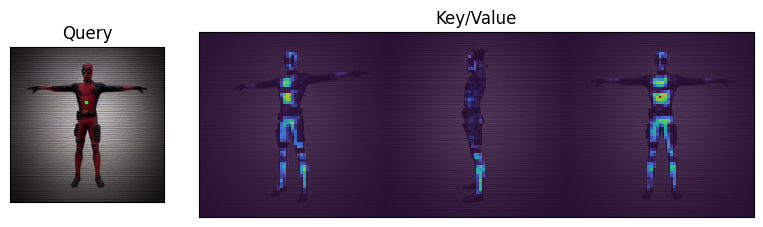

In [78]:
from typing import List
from PIL.Image import Image

from text3d2video.attention_visualization import add_pixel_marker, compute_attn_weights, concatenate_images, coord_to_pixel, make_gridspec_figure, pixel_coord_flattened, plot_image_and_weight, reshape_concatenated

def plot_attn_weights(
    qry: Tensor,
    key: Tensor,
    qry_coord: Tensor,
    images: List[Image],
    qry_idx: int,
    kv_indices: int,
    head_index=2,
):
    layer_res = 64

    # get q/k for head
    qry_mh = split_heads(qry.unsqueeze(0))
    key_mh = split_heads(key.unsqueeze(0))
    qry_head = qry_mh[0, :, head_index, :]
    key_head = key_mh[0, :, head_index, :]

    # setup figure
    fig, gs = make_gridspec_figure(
        1, 2, width_ratios=[1, 4], height_ratios=[1], scale=2
    )
    ax_qry = fig.add_subplot(gs[0, 0])
    ax_kv = fig.add_subplot(gs[0, 1])
    for ax in [ax_kv, ax_qry]:
        ax.set_xticks([])
        ax.set_yticks([])
    ax_qry.set_title("Query")
    ax_kv.set_title("Key/Value")

    qry_im = images[qry_idx]
    qry_grid_size = (layer_res, layer_res)

    # plot query image with marker
    ax_qry.imshow(qry_im)
    add_pixel_marker(ax_qry, qry_coord, qry_im.size, qry_grid_size)

    # get query pixel coordinate
    qry_pix = coord_to_pixel(qry_coord, qry_grid_size)
    qry_pix_1d = pixel_coord_flattened(qry_pix, qry_grid_size)

    # compute attn weights
    attn_weights = compute_attn_weights(qry_head.unsqueeze(0), key_head.unsqueeze(0))[0]
    weights = attn_weights[qry_pix_1d, :]
    weights = reshape_concatenated(weights.unsqueeze(-1), layer_res=layer_res)[0]

    # get images
    kv_im = concatenate_images([images[idx] for idx in kv_indices])
    plot_image_and_weight(ax_kv, kv_im, weights, interpolation="nearest", alpha=0.8)

qry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)

plot_attn_weights(qry, key, Tensor([0.49, 0.35]), video_frames, 0, kf_indices.int().tolist())

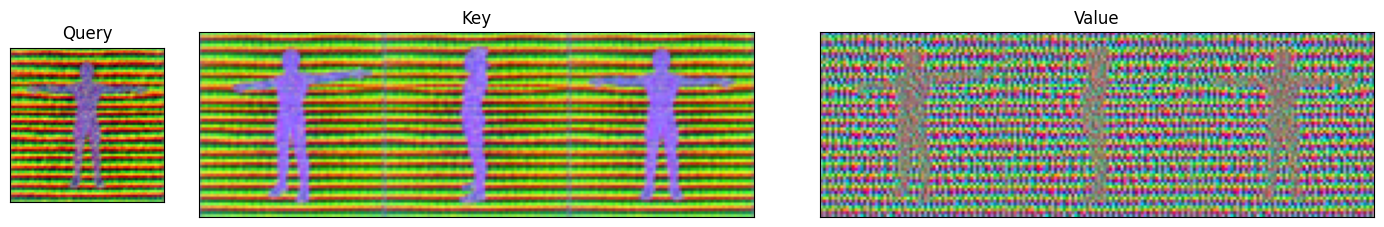

In [67]:
from einops import rearrange

from text3d2video.attention_visualization import split_heads
from text3d2video.feature_visualization import RgbPcaUtil, reduce_feature_map
from text3d2video.ipython_utils import display_ims_grid

layer_res = attn_layer.layer_resolution(pipe.unet)
qry_square = rearrange(qry_head, "(h w) d -> d h w", h=layer_res)
key_square = reshape_concatenated(key_head, layer_res)
val_square = reshape_concatenated(val_head, layer_res)

qk_features = torch.cat([qry_head, key_head], dim=0)
pca_qk = RgbPcaUtil.init_from_features(qk_features)

val_rgb = reduce_feature_map(val_square)
qry_rgb = pca_qk.feature_map_to_rgb_pil(qry_square)
key_rgb = pca_qk.feature_map_to_rgb_pil(key_square)

fig, gs_kf = make_gridspec_figure(1, 3, width_ratios=[1, 4, 4], height_ratios=[1])
ax_qry = fig.add_subplot(gs_kf[0, 0])
ax_key = fig.add_subplot(gs_kf[0, 1])
ax_val = fig.add_subplot(gs_kf[0, 2])

ax_qry.imshow(qry_rgb)
ax_key.imshow(key_rgb)
ax_val.imshow(val_rgb)

ax_qry.set_title("Query")
ax_key.set_title("Key")
ax_val.set_title("Value")

for ax in [ax_qry, ax_key, ax_val]:
    ax.set_xticks([])
    ax.set_yticks([])